In [1]:
import os
import sys

parent = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent)

from compartment import SIRModel, SEIRModel

import jax
import jax.numpy as np
import matplotlib.pyplot as plt

R0 2.8
lambda 0.23999999999999996
final [7.5025336e+04 2.7894792e-01 9.2497412e+05 9.2497400e+05]


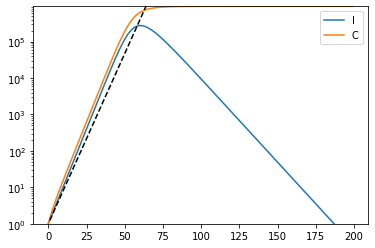

R0 2.8
lambda 0.2558581
final [7.5025281e+04 2.7915453e-06 1.4291726e-06 9.2497419e+05 9.2497444e+05]


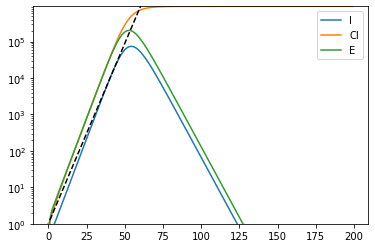

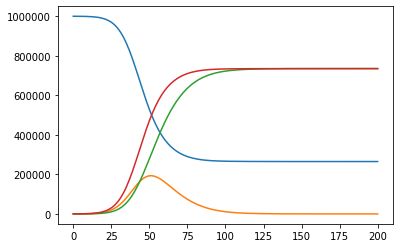

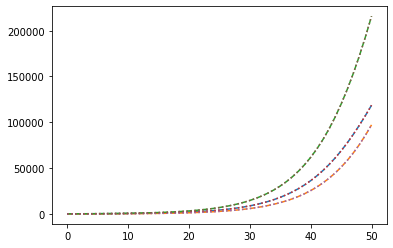

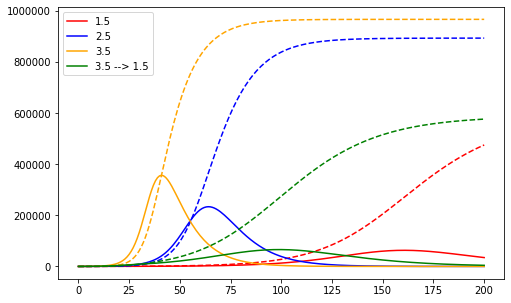

999900.0
(DeviceArray(999900., dtype=float32), DeviceArray(-1., dtype=float32))
999900.0
(DeviceArray(999900., dtype=float32), DeviceArray(-1., dtype=float32))


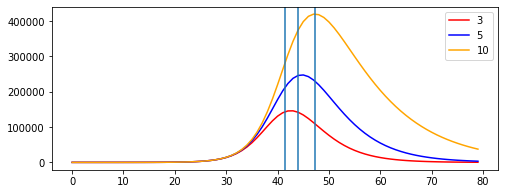

In [5]:
ramp = np.linspace
def extend(x, T):
    t = len(x)
    return x if t >= T else np.hstack((x, x[-1]*np.ones(T-t)))


def test_SIR(R0=2.8, T=200):

    gamma = 1.0/7.5
    beta =  R0 * gamma
    
    SIR = SIRModel

    x0 = SIR.seed(1e6, 1)
    theta = (beta, gamma)
    X = SIR.run(T, x0, theta)
    
    R0 = SIR.R0(theta)
    r = SIR.growth_rate(theta)
    
    print("R0", R0)
    print("lambda", r)
    print("final", X[-1])
    
    cols = [1, 3]
    labels = ['S', 'I', 'R', 'C']
    plt.plot(X[:,cols])
    plt.legend([labels[c] for c in cols])

    t = np.arange(1,T)
    plt.plot(t, (1+r)**t, '--', color='k')
    plt.yscale('log')
    plt.ylim([1, X[:, cols].max()])
    
    plt.show()

def test_SEIR(R0 = 2.8, T=200):
        
    gamma = 1.0/1.5
    sigma = 1.0/4.0
    beta = R0 * gamma
    
    SEIR = SEIRModel

    x0 = SEIR.seed(1e6, 1)
    theta = (beta, sigma, gamma)
    X = SEIR.run(T, x0, theta)

    R0 = SEIR.R0(theta)
    r = SEIR.growth_rate(theta)
    
    print("R0", R0)
    print("lambda", r)
    print("final", X[-1])

    cols = [2, 4, 1]
    labels = ['S', 'E', 'I', 'R', 'CI']

    plt.plot(X[:,cols])
    plt.legend([labels[c] for c in cols])
    
    t = np.arange(1, T)
    plt.plot(t, (1+r)**t, '--', color='k')
    plt.yscale('log')
    plt.ylim([1, X[:, cols].max()])

    plt.show()


def test_SIR_time_varying():
    T = 201
    beta0 = 3.5/10.0
    beta1 = 0.5/10.0
    beta = extend(ramp(beta0, beta1, 100), T-1)

    gamma = 1.0/10.0

    SIR = SIRModel
    
    x0 = SIR.seed(1e6, 100)
    X = SIR.run(T, x0, (beta, gamma))
    plt.plot(X)
    plt.show()

    
def compare_static_varying():
    # compare to see if dynamics are (nearly) the same when time-varying
    # function is used by parameters do not vary with time
    
    T = 51
    beta = 2.5/10.0
    gamma = 1.0/10.0
    
    SIR = SIRModel
    
    x0 = SIR.seed(1e6, 100)    
    
    X1 = SIR.run(T, x0, (beta, gamma))
    
    beta = np.repeat(beta, T-1)
    X2 = SIR.run(T, x0, (beta, gamma))

    plt.plot(X1[:,1:], linestyle='--')
    plt.plot(X2[:,1:], linestyle=':')
    plt.show()

def compare_SIR():
    
    # look at the qualitative difference between model with constant
    # dynamics and time-varying dynamics
    
    T = 201
    gamma = 1/10
    
    R0_vals = [1.5, 2.5, 3.5]
    colors = ['r', 'b', 'orange']

    plt.figure(figsize=(8,5))
    
    
    SIR = SIRModel
    x0 = SIR.seed(1e6, 100)
    
    for R0, color in zip(R0_vals, colors):
        beta = R0*gamma
        x = SIR.run(T, x0, (beta, gamma))
        plt.plot(x[:,1], color=color, linestyle='-')
        plt.plot(x[:,2], color=color, linestyle='--')        

    # Test time-varying dynamics
    R0 = extend(ramp(3.5, 1.5, 30), T-1)
    beta = R0 * gamma
    x = SIR.run(T, x0, (beta, gamma))
    plt.plot(x[:,1], color='g', linestyle='-')
    plt.plot(x[:,2], color='g', linestyle='--')
    
    plt.legend(plt.gca().lines[::2], R0_vals + ['3.5 --> 1.5'])
    plt.show()

    
def fixed_growth_rate():

    # Compare SIR curves with same growth rate but different gamma
    T = 80
    offset = 0.32
    N = 1e6
    
    durations = [3, 5, 10]
    colors = ['r', 'b', 'orange']

    lines = []
    plt.figure(figsize=(8,3))
    
    SIR = SIRModel
    x0 = SIR.seed(N, 1)
    
    for duration, color in zip(durations, colors):
        
        gamma = 1./duration
        beta = gamma + offset
    
        X = SIR.run(T, x0, (beta, gamma))
        lines += plt.plot(X[:,1], linestyle='-', color=color)
        #plt.plot(X[:,2], linestyle='--', color=color)
        plt.plot()
    
    plt.legend(lines, durations)

    for c in [0.1, 0.2, 0.5]:
        peak_heuristic = (np.log(c) + np.log(N))/np.log(1.32)
        plt.axvline(peak_heuristic)


def test_backprop():
    def f(I):
        T = 5
        SIR = SIRModel
        x0 = SIR.seed(1e6, I)
        gamma = 1./5.
        beta = 3./5.
        x = SIR.run(T, x0, (beta, gamma))
        return x[0][0]

    print(f(100.))
    print(jax.value_and_grad(f)(100.))

    def g(I):
        T = 5
        SEIR = SEIRModel
        x0 = SEIR.seed(1e6, I)
        sigma = 1/5.
        gamma = 1./1.
        beta = 3./5.
        x = SEIR.run(T, x0, (beta, sigma, gamma))
        return x[0][0]

    print(g(100.))
    print(jax.value_and_grad(g)(100.))

        
run_tests = True

if run_tests:
    test_SIR()
    test_SEIR()
    test_SIR_time_varying()
    compare_static_varying()
    compare_SIR()
    fixed_growth_rate()
    test_backprop()

R0 3.4999999999999996
lambda 0.33333334
final [ 3.4015215e+04  7.0272499e-09 -1.1024786e-08  9.6598469e+05
  9.6598519e+05]


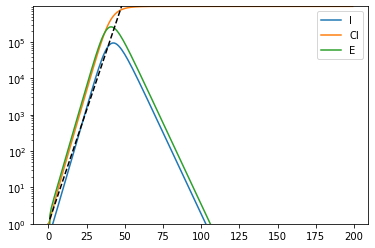

In [6]:
def test_SEIR(R0=3.5, T=200):
        
    gamma = 1.0/1.5
    sigma = 1.0/4.0
    beta = R0 * gamma
    
    SEIR = SEIRModel

    x0 = SEIR.seed(1e6, 1)
    theta = (beta, sigma, gamma)
    X = SEIR.run(T, x0, theta)

    R0 = SEIR.R0(theta)
    r = SEIR.growth_rate(theta)
    
    print("R0", R0)
    print("lambda", r)
    print("final", X[-1])

    cols = [2, 4, 1]
    labels = ['S', 'E', 'I', 'R', 'CI']

    plt.plot(X[:,cols])
    plt.legend([labels[c] for c in cols])
    
    t = np.arange(1, T)
    plt.plot(t, (1+r)**t, '--', color='k')
    plt.yscale('log')
    plt.ylim([1, X[:, cols].max()])

    plt.show()

test_SEIR()